/var/folders/q0/f4378byd6qdfkx4nnwfw_rk80000gn/T/ipykernel_16746/2381680550.py:24: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, speech_data = wavfile.read(file_path)


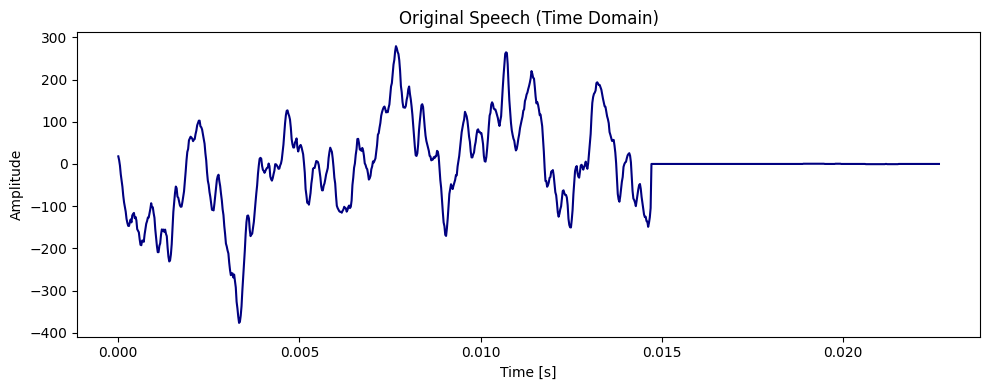

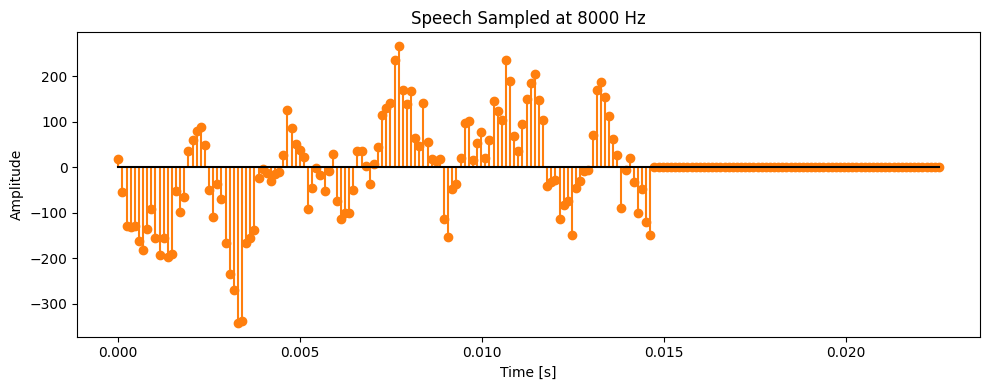

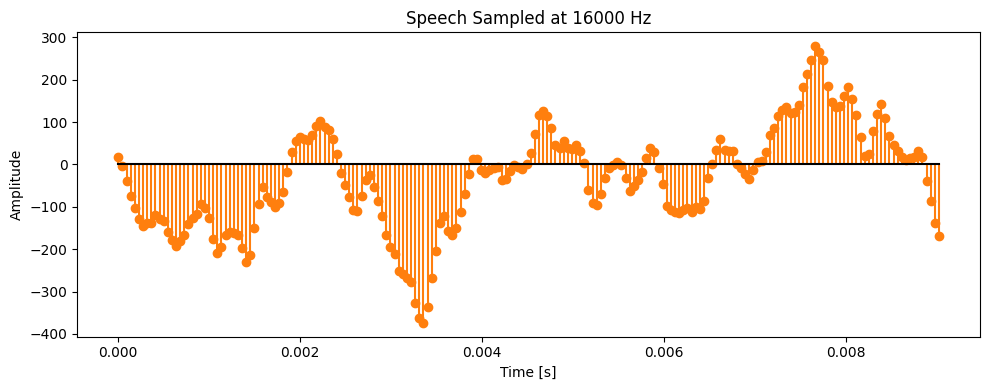

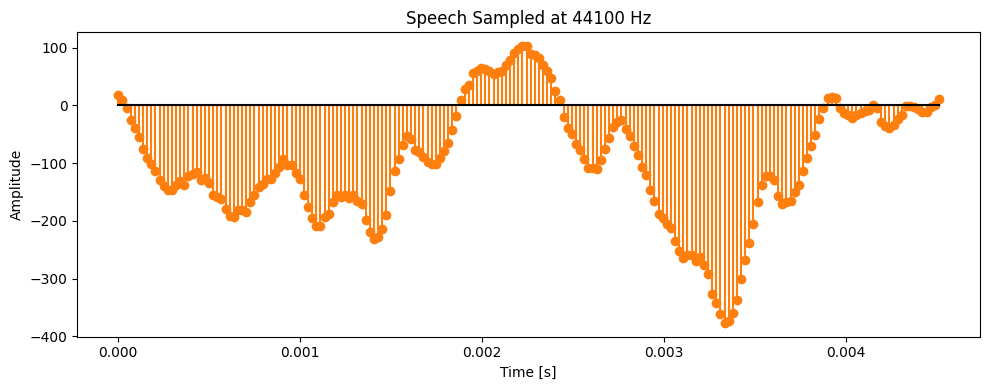


Sampling Rate: 8000 Hz
MSE (ZOH): 30908.129074
MSE (Linear): 957.683683


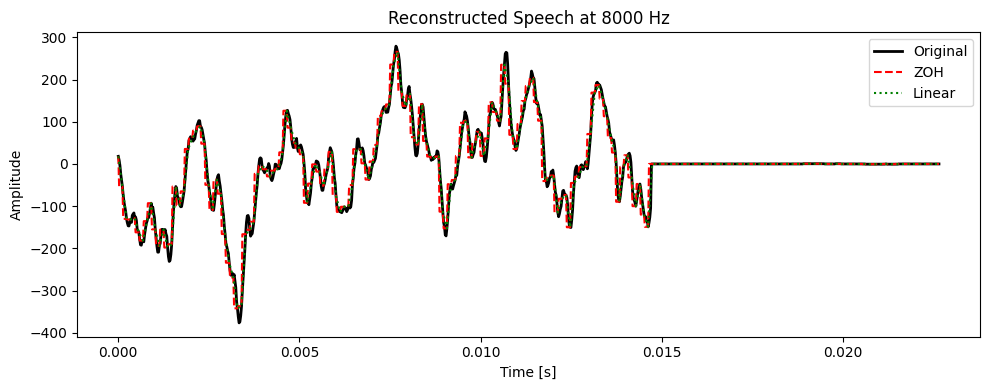


Sampling Rate: 16000 Hz
MSE (ZOH): 2686.497417
MSE (Linear): 42.504107


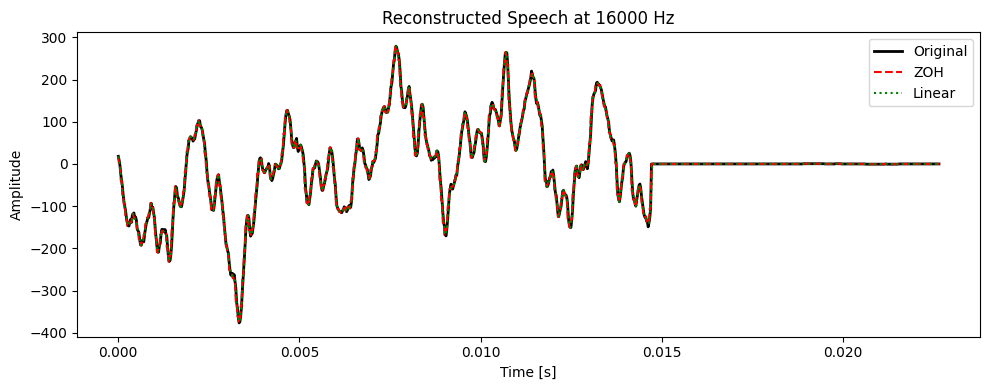


Sampling Rate: 44100 Hz
MSE (ZOH): 0.000000
MSE (Linear): 0.000000


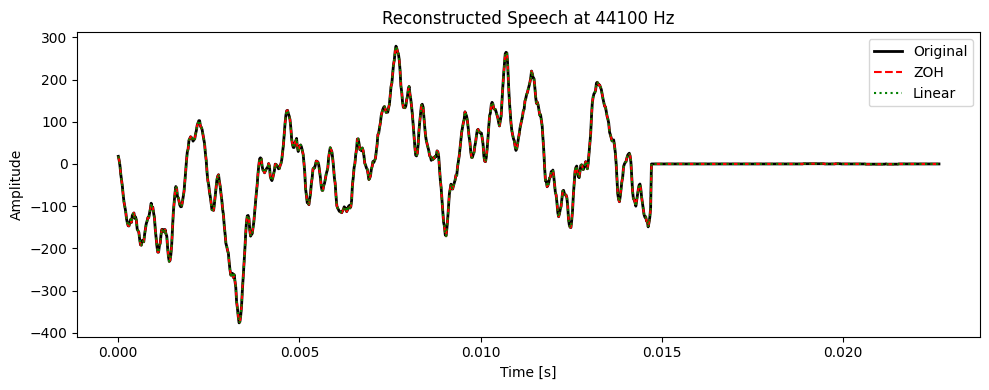

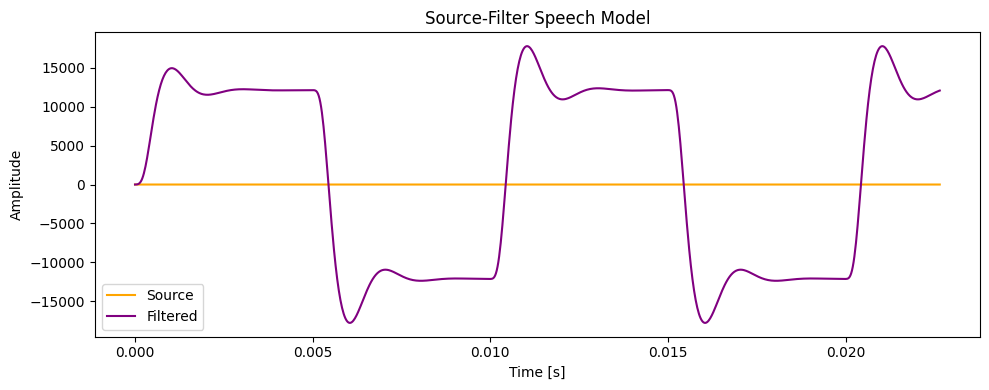


[Synth Speech] Sampling Rate: 8000 Hz
MSE (ZOH): 819988.239379
MSE (Linear): 4635.639119


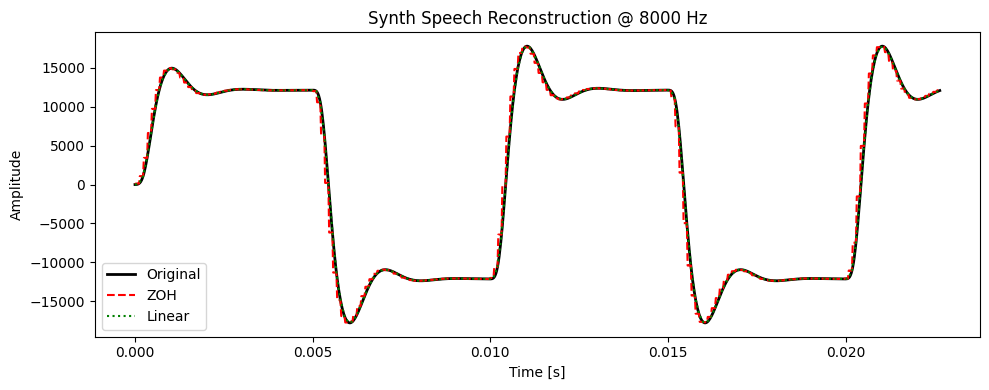


[Synth Speech] Sampling Rate: 16000 Hz
MSE (ZOH): 68738.455871
MSE (Linear): 113.594214


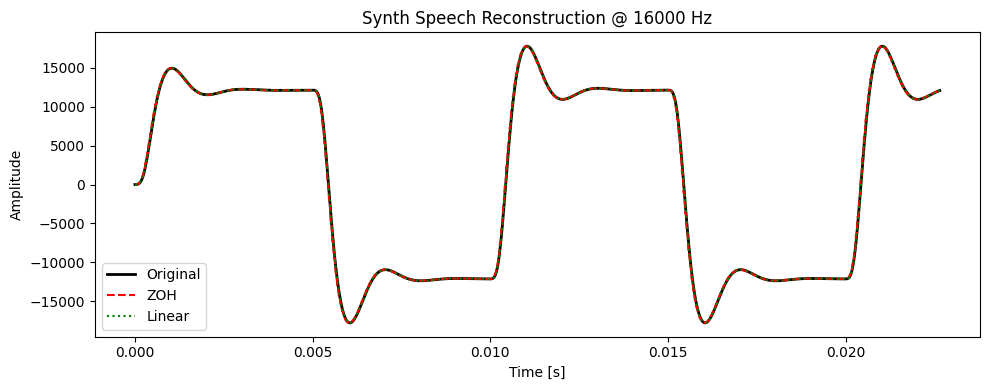


[Synth Speech] Sampling Rate: 44100 Hz
MSE (ZOH): 0.000000
MSE (Linear): 0.000000


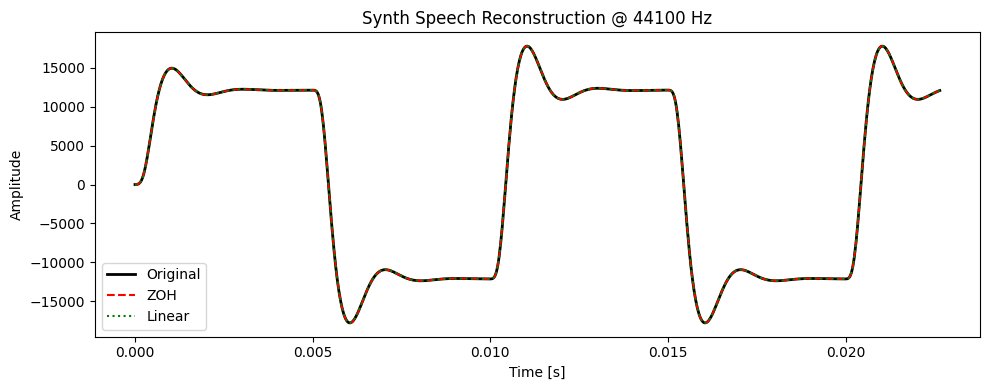

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

# -------------------------------
# Functions for reconstruction
# -------------------------------
def reconstruct_zoh(samples, sample_times, target_times):
    indices = np.searchsorted(sample_times, target_times, side='left')
    indices = np.clip(indices, 0, len(samples)-1)
    return samples[indices]

def reconstruct_linear(samples, sample_times, target_times):
    return np.interp(target_times, sample_times, samples)

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# -------------------------------
# Load custom speech
# -------------------------------
file_path = "/Users/luqmaan/Desktop/SPR/BAK.wav"  
fs, speech_data = wavfile.read(file_path)

# Convert stereo to mono if needed
if len(speech_data.shape) > 1:
    speech_data = speech_data.mean(axis=1)

# Normalize
if speech_data.dtype != np.float32 and speech_data.dtype != np.float64:
    speech_data = speech_data.astype(np.float32)
    speech_data /= np.max(np.abs(speech_data))

time_axis = np.linspace(0, len(speech_data)/fs, len(speech_data), endpoint=False)

# Plot original speech
plt.figure(figsize=(10,4))
plt.plot(time_axis[:1000], speech_data[:1000], color='navy')
plt.title("Original Speech (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# -------------------------------
# Sampling at different rates
# -------------------------------
sample_rates = [8000, 16000, fs]
sampled_signals = {}
sampled_times = {}

for sr in sample_rates:
    step_size = max(1, int(fs/sr))
    sampled_signals[sr] = speech_data[::step_size]
    sampled_times[sr] = time_axis[::step_size]

    points_to_plot = min(200, len(sampled_times[sr]))
    plt.figure(figsize=(10,4))
    plt.stem(sampled_times[sr][:points_to_plot], sampled_signals[sr][:points_to_plot], linefmt='C1-', markerfmt='C1o', basefmt="k-")
    plt.title(f"Speech Sampled at {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# -------------------------------
# Reconstruction & Error
# -------------------------------
for sr in sample_rates:
    zoh_recon = reconstruct_zoh(sampled_signals[sr], sampled_times[sr], time_axis)
    lin_recon = reconstruct_linear(sampled_signals[sr], sampled_times[sr], time_axis)

    mse_zoh = calculate_mse(speech_data, zoh_recon)
    mse_lin = calculate_mse(speech_data, lin_recon)

    print(f"\nSampling Rate: {sr} Hz")
    print(f"MSE (ZOH): {mse_zoh:.6f}")
    print(f"MSE (Linear): {mse_lin:.6f}")

    plt.figure(figsize=(10,4))
    plt.plot(time_axis[:1000], speech_data[:1000], color='black', label='Original', linewidth=2)
    plt.plot(time_axis[:1000], zoh_recon[:1000], '--', color='red', label='ZOH')
    plt.plot(time_axis[:1000], lin_recon[:1000], ':', color='green', label='Linear')
    plt.title(f"Reconstructed Speech at {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------
# Source-Filter Speech Synthesis
# -------------------------------
# Source signal: glottal pulse train
fund_freq = 100
source_signal = 0.5 * signal.square(2*np.pi*fund_freq*time_axis)

# Vocal tract filter (formants)
formants = [500, 1500, 2500]  # Hz
a_coeff = [1.0]
b_coeff = [1.0]

for f in formants:
    r = np.exp(-np.pi*f/fs)
    theta = 2*np.pi*f/fs
    a_coeff = np.convolve(a_coeff, [1, -2*r*np.cos(theta), r**2])

synth_speech = signal.lfilter(b_coeff, a_coeff, source_signal)

# Plot source and filtered speech
plt.figure(figsize=(10,4))
plt.plot(time_axis[:1000], source_signal[:1000], label='Source', color='orange')
plt.plot(time_axis[:1000], synth_speech[:1000], label='Filtered', color='purple')
plt.title("Source-Filter Speech Model")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Sampling & Reconstruction of Synthesized Speech
# -------------------------------
for sr in sample_rates:
    step_size = max(1, int(fs/sr))
    sampled_synth = synth_speech[::step_size]
    sampled_time_synth = time_axis[::step_size]

    zoh_recon = reconstruct_zoh(sampled_synth, sampled_time_synth, time_axis)
    lin_recon = reconstruct_linear(sampled_synth, sampled_time_synth, time_axis)

    mse_zoh = calculate_mse(synth_speech, zoh_recon)
    mse_lin = calculate_mse(synth_speech, lin_recon)

    print(f"\n[Synth Speech] Sampling Rate: {sr} Hz")
    print(f"MSE (ZOH): {mse_zoh:.6f}")
    print(f"MSE (Linear): {mse_lin:.6f}")

    plt.figure(figsize=(10,4))
    plt.plot(time_axis[:1000], synth_speech[:1000], label='Original', color='black', linewidth=2)
    plt.plot(time_axis[:1000], zoh_recon[:1000], '--', label='ZOH', color='red')
    plt.plot(time_axis[:1000], lin_recon[:1000], ':', label='Linear', color='green')
    plt.title(f"Synth Speech Reconstruction @ {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()